In [3]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from itertools import product
from sklearn.metrics import roc_curve, auc

In [4]:
train = pd.read_csv('train_classification.csv')
test = pd.read_csv('test_classification.csv')

In [5]:
# Only getting observations with out_prncp_inv not equal to 0
train_1 = train.loc[train.out_prncp_inv != 0]

In [6]:
train_1.head()

,id,hi_int_prncp_pd,acc_now_delinq,acc_open_past_24mths,addr_state,annual_inc,application_type,avg_cur_bal,bc_util,delinq_2yrs,...,out_prncp_inv,pub_rec,pub_rec_bankruptcies,purpose,sub_grade,term,tot_coll_amt,tot_cur_bal,total_rec_late_fee,verification_status
2,3821,1,0,2,IL,80000.0,Individual,15316,57.7,1,...,9099.27,0,0,debt_consolidation,C1,60 months,168,183792,0.0,Not Verified
7,3826,1,0,5,MA,68000.0,Individual,17072,41.2,1,...,2824.63,0,0,home_improvement,B5,36 months,0,204865,30.0,Not Verified
8,3827,0,0,1,MI,10000.0,Joint App,4872,0.0,0,...,17978.39,0,0,house,B5,60 months,0,29232,0.0,Not Verified
9,3828,1,0,4,RI,22000.0,Individual,1432,73.4,0,...,10022.34,0,0,debt_consolidation,C4,36 months,0,11455,0.0,Source Verified
10,3829,1,0,7,NC,85000.0,Individual,1348,85.2,0,...,9807.57,0,0,debt_consolidation,D3,60 months,0,31002,0.0,Source Verified


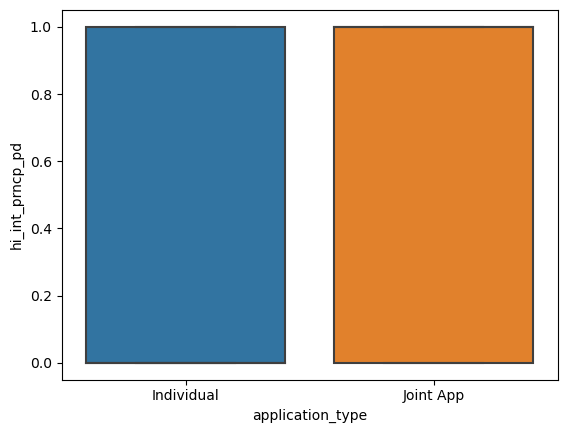

In [7]:
sns.boxplot(y = 'hi_int_prncp_pd', x = 'application_type', data = train_1)
plt.show()

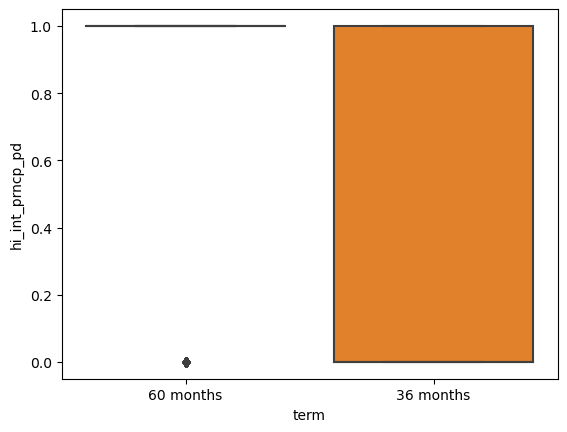

In [8]:
sns.boxplot(y = 'hi_int_prncp_pd', x = 'term', data = train_1)
plt.show()

In [9]:
train_dummy = pd.get_dummies(train_1[['application_type', 'term']])
train_dummy['id'] = train_1['id']
train_1 = train_1.merge(train_dummy, on = 'id')
train_1.head()

,id,hi_int_prncp_pd,acc_now_delinq,acc_open_past_24mths,addr_state,annual_inc,application_type,avg_cur_bal,bc_util,delinq_2yrs,...,sub_grade,term,tot_coll_amt,tot_cur_bal,total_rec_late_fee,verification_status,application_type_Individual,application_type_Joint App,term_36 months,term_60 months
0,3821,1,0,2,IL,80000.0,Individual,15316,57.7,1,...,C1,60 months,168,183792,0.0,Not Verified,1,0,0,1
1,3826,1,0,5,MA,68000.0,Individual,17072,41.2,1,...,B5,36 months,0,204865,30.0,Not Verified,1,0,1,0
2,3827,0,0,1,MI,10000.0,Joint App,4872,0.0,0,...,B5,60 months,0,29232,0.0,Not Verified,0,1,0,1
3,3828,1,0,4,RI,22000.0,Individual,1432,73.4,0,...,C4,36 months,0,11455,0.0,Source Verified,1,0,1,0
4,3829,1,0,7,NC,85000.0,Individual,1348,85.2,0,...,D3,60 months,0,31002,0.0,Source Verified,1,0,0,1


In [10]:
test_dummy = pd.get_dummies(test[['application_type', 'term']])
test_dummy['id'] = test['id']
test = test.merge(test_dummy, on = 'id')
test.head()

,id,acc_now_delinq,acc_open_past_24mths,addr_state,annual_inc,application_type,avg_cur_bal,bc_util,delinq_2yrs,delinq_amnt,...,sub_grade,term,tot_coll_amt,tot_cur_bal,total_rec_late_fee,verification_status,application_type_Individual,application_type_Joint App,term_36 months,term_60 months
0,1,0,2,NV,59500.0,Individual,2652,37.0,0,0,...,A2,36 months,0,26517,0.00,Verified,1,0,1,0
1,2,0,2,CA,140000.0,Individual,14868,21.4,1,0,...,A1,36 months,5027,74341,0.00,Not Verified,1,0,1,0
2,3,0,6,FL,65000.0,Individual,14826,0.0,0,0,...,B5,60 months,100,177915,0.00,Source Verified,1,0,0,1
3,4,0,0,CA,52300.0,Individual,12696,90.6,1,0,...,B3,36 months,0,152357,51.62,Source Verified,1,0,1,0
4,5,0,5,IL,89000.0,Individual,21720,79.3,0,0,...,C4,60 months,0,325807,0.00,Verified,1,0,0,1


In [11]:
train_1 = train_1.rename(columns={"application_type_Joint App": "Joint_app", "application_type_Individual" : "Individual_app",
                      "term_36 months": "term_36_months", "term_60 months":"term_60_months"})

In [12]:
test = test.rename(columns={"application_type_Joint App": "Joint_app", "application_type_Individual" : "Individual_app",
                      "term_36 months": "term_36_months", "term_60 months":"term_60_months"})

In [13]:
model11 = sm.ols('hi_int_prncp_pd ~ acc_now_delinq + acc_open_past_24mths + annual_inc +\
avg_cur_bal + bc_util + delinq_2yrs + delinq_amnt + dti +\
int_rate + loan_amnt + mort_acc + num_sats + \
num_tl_120dpd_2m + num_tl_90g_dpd_24m + num_tl_30dpd + out_prncp_inv + pub_rec + pub_rec_bankruptcies +\
tot_coll_amt + tot_cur_bal + total_rec_late_fee', data = train_1).fit()
model11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        hi_int_prncp_pd   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     40.96
Date:                Mon, 20 Mar 2023   Prob (F-statistic):          3.86e-137
Time:                        01:50:35   Log-Likelihood:                -1400.1
No. Observations:                2444   AIC:                             2842.
Df Residuals:                    2423   BIC:                             2964.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.1896      0.039     -4.881      0.000      -0.266      -0.113
acc_now_delinq          -0.1869      0.434     -0.431      0.667      -1.037       0.663
acc_open_past_24mths    -0.0055      0.003     -1.579      0.114      -0.012       0.001
annual_inc           -2.885e-08   4.87e-08     -0.593      0.553   -1.24e-07    6.66e-08
avg_cur_bal           6.121e-08   1.14e-06      0.054      0.957   -2.17e-06    2.29e-06
bc_util                 -0.0002      0.000     -0.457      0.648      -0.001       0.001
delinq_2yrs             -0.0108      0.013     -0.826      0.409      -0.036       0.015
delinq_amnt          -6.845e-05   4.18e-05     -1.637      0.102      -0.000    1.35e-05
dti                     -0.0018      0.001     -1.742      0.082      -0.004       0.000
int_rate                 0.0458      0.002     22.287      0.000       0.042       0.050
loan_amnt            -4.636e-06   1.68e-06     -2.764      0.006   -7.92e-06   -1.35e-06
mort_acc                 0.0099      0.006      1.748      0.081      -0.001       0.021
num_sats                 0.0028      0.002      1.247      0.213      -0.002       0.007
num_tl_120dpd_2m     -5.727e-16   8.69e-16     -0.659      0.510   -2.28e-15    1.13e-15
num_tl_90g_dpd_24m      -0.0025      0.025     -0.099      0.921      -0.052       0.047
num_tl_30dpd            -0.0102      0.474     -0.022      0.983      -0.940       0.920
out_prncp_inv         1.677e-05   1.92e-06      8.744      0.000     1.3e-05    2.05e-05
pub_rec                  0.0341      0.027      1.275      0.203      -0.018       0.087
pub_rec_bankruptcies    -0.0715      0.040     -1.771      0.077      -0.151       0.008
tot_coll_amt         -1.413e-05   6.47e-06     -2.183      0.029   -2.68e-05   -1.44e-06
tot_cur_bal           -5.61e-08   1.24e-07     -0.453      0.651   -2.99e-07    1.87e-07
total_rec_late_fee       0.0002      0.001      0.418      0.676      -0.001       0.001
==============================================================================
Omnibus:                      239.735   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.946
Skew:                           0.132   Prob(JB):                     1.96e-17
Kurtosis:                       2.172   Cond. No.                     7.15e+22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.38e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [14]:
#Creating a set of predictors from which we need to find the best subset of predictors
X = train_1[['acc_now_delinq', 'acc_open_past_24mths', 'annual_inc', 'avg_cur_bal',
       'bc_util', 'delinq_2yrs', 'delinq_amnt', 'dti', 'int_rate', 'loan_amnt',
       'mort_acc', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_90g_dpd_24m',
       'num_tl_30dpd', 'out_prncp_inv', 'pub_rec', 'pub_rec_bankruptcies',
       'tot_coll_amt', 'tot_cur_bal', 'total_rec_late_fee']]

In [15]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.ols('hi_int_prncp_pd ~' + '+'.join(predictor_subset),data = train_1).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}

In [16]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [17]:
def forward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [18]:
models_best = forward_selection()

Processed  21 models on 1 predictors in 0.13415193557739258 seconds.
Processed  20 models on 2 predictors in 0.24360299110412598 seconds.
Processed  19 models on 3 predictors in 0.29598093032836914 seconds.
Processed  18 models on 4 predictors in 0.29174089431762695 seconds.
Processed  17 models on 5 predictors in 0.3329348564147949 seconds.
Processed  16 models on 6 predictors in 0.3433499336242676 seconds.
Processed  15 models on 7 predictors in 0.3779618740081787 seconds.
Processed  14 models on 8 predictors in 0.3929717540740967 seconds.
Processed  13 models on 9 predictors in 0.3508141040802002 seconds.
Processed  12 models on 10 predictors in 0.400676965713501 seconds.
Processed  11 models on 11 predictors in 0.29543018341064453 seconds.
Processed  10 models on 12 predictors in 0.28959202766418457 seconds.
Processed  9 models on 13 predictors in 0.348038911819458 seconds.
Processed  8 models on 14 predictors in 0.3077058792114258 seconds.
Processed  7 models on 15 predictors in 0

In [19]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')

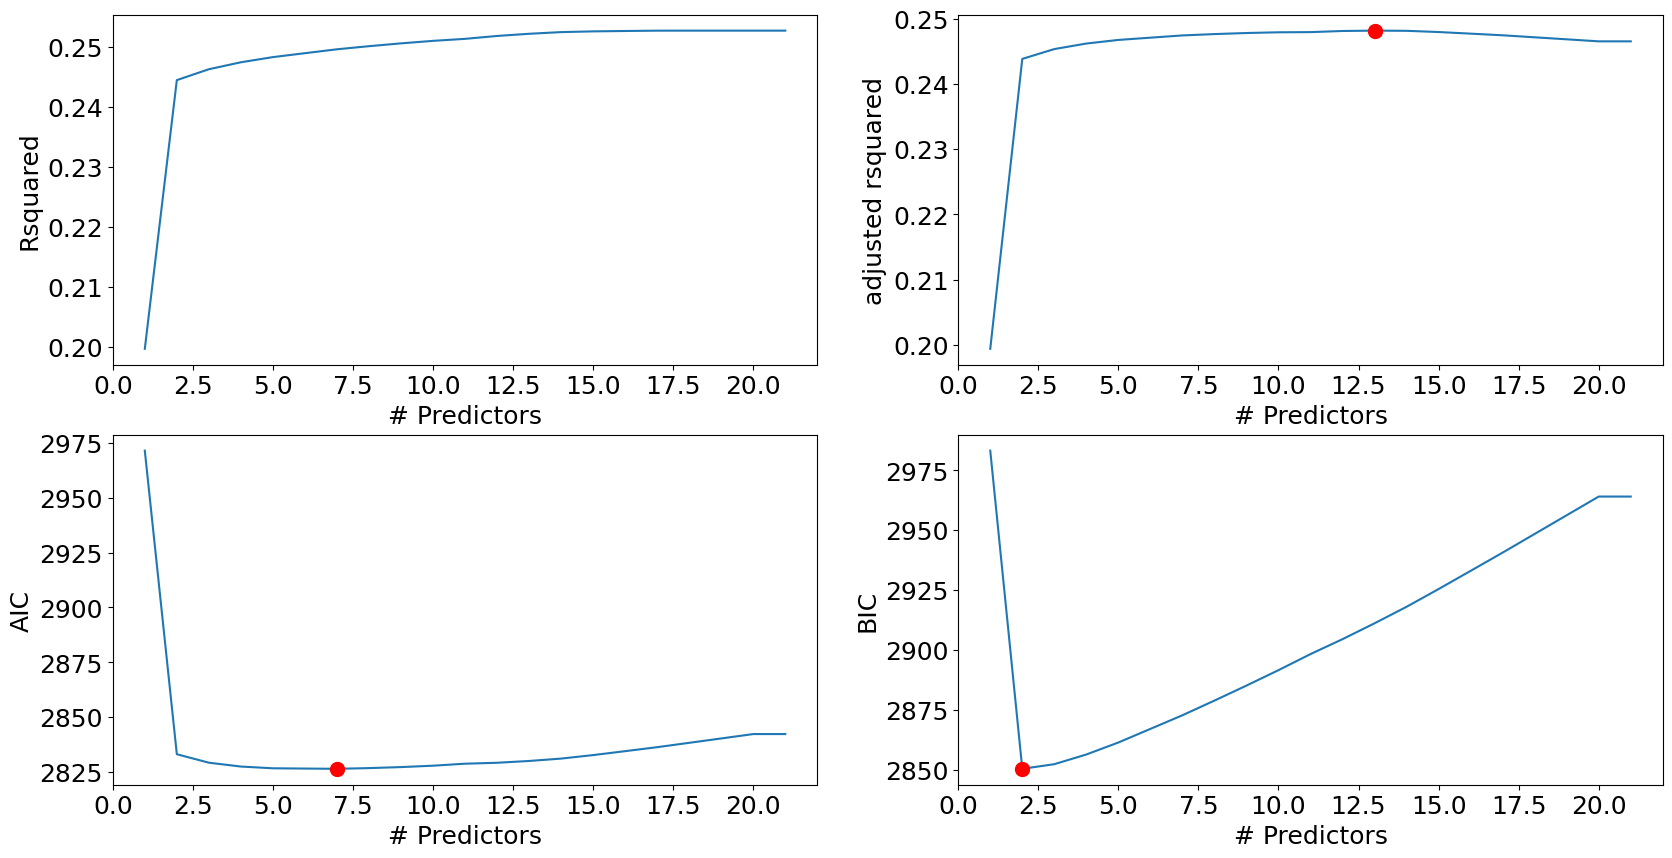

In [20]:
best_sub_plots()

In [21]:
best_fwd_reg_model = models_best['model'][7]
best_fwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        hi_int_prncp_pd   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     115.7
Date:                Mon, 20 Mar 2023   Prob (F-statistic):          6.44e-147
Time:                        01:50:47   Log-Likelihood:                -1405.2
No. Observations:                2444   AIC:                             2826.
Df Residuals:                    2436   BIC:                             2873.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.1961      0.032     -6.187      0.000      -0.258      -0.134
int_rate          0.0446      0.002     23.904      0.000       0.041       0.048
out_prncp_inv  1.671e-05   1.88e-06      8.884      0.000     1.3e-05    2.04e-05
loan_amnt     -4.421e-06   1.63e-06     -2.713      0.007   -7.62e-06   -1.23e-06
tot_coll_amt  -1.295e-05   6.44e-06     -2.009      0.045   -2.56e-05   -3.13e-07
delinq_amnt   -7.107e-05   4.17e-05     -1.706      0.088      -0.000    1.06e-05
dti              -0.0014      0.001     -1.488      0.137      -0.003       0.000
mort_acc          0.0069      0.005      1.453      0.146      -0.002       0.016
==============================================================================
Omnibus:                      270.060   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.164
Skew:                           0.141   Prob(JB):                     1.44e-18
Kurtosis:                       2.147   Cond. No.                     8.28e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.28e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
# Predictor_set = trial and erros
predictor_set = ['out_prncp_inv','loan_amnt','mort_acc','int_rate','total_rec_late_fee','bc_util']
from itertools import product
values = np.arange(0,6)
polynomial_transformations = pd.DataFrame(product(values, repeat=6), columns=predictor_set).loc[1:,]
polynomial_transformations.loc[:,'sum_degree'] = (polynomial_transformations).astype(int).sum(axis=1)
polynomial_transformations.loc[:,'count_zeros'] = (polynomial_transformations == 0).astype(int).sum(axis=1)
polynomial_transformations.sort_values(by = ['count_zeros', 'sum_degree'], ascending=[False, True], inplace=True)
polynomial_transformations.drop(columns = ['count_zeros'], inplace=True)
polynomial_transformations.reset_index(inplace = True, drop = True)

In [23]:
#Setting the seed as we are shuffling the data before splitting it into K-folds
np.random.seed(123)
# Shuffling the training set before creating K folds
train = train_1.sample(frac=1)
k = 7 #5-fold cross validation
fold_size = np.round(train_1.shape[0]/k)

In [24]:
def KFoldCV(selected_interactions, interaction_being_tested):
    cv_vals = []
    for ii in range(k):
        val_indices = np.arange(ii*(fold_size),(ii+1)*fold_size)
        val_set = train_1.iloc[val_indices, :]
        train_set = train_1.drop(train_1.iloc[val_indices, :].index.tolist())
        model = sm.logit('hi_int_prncp_pd~out_prncp_inv+loan_amnt+mort_acc+int_rate+Joint_app+\
        Individual_app+term_36_months+term_60_months+total_rec_late_fee+bc_util'+selected_interactions+\
                       interaction_being_tested, data = train_set).fit()
        pred_price = model.predict(val_set)     
        cv_vals.append(np.sqrt(((val_set['hi_int_prncp_pd']-pred_price)**2).mean()))
    return (np.mean(cv_vals))

In [25]:
# 5-fold cross validation RMSE of the initial model with the 4 predictors of degree one
cv_previous_model = KFoldCV(selected_interactions = '', interaction_being_tested = '')
interaction_being_tested = '+'
selected_interactions = ''

# Considering interactions of degree 'd' = 2 to 12
for d in np.arange(2,13):
    
    # Selecting interaction terms of degree = 'd'
    degree_set = polynomial_transformations.loc[polynomial_transformations.sum_degree==d, :]
    
    # Initializing objects to store the interactions of degree 'd' that reduce the
    # 5-fold cross validation RMSEs as compared to the previous model
    interactions_that_reduce_KfoldCV = []; cv_degree = []; 
    
    # Creating another DataFrame that will consist of the updated set of interactions of degree 'd' to be considered
    # as interactions that do not reduce the 5-fold cross validation RMSE will be discarded
    degree_set_updated = pd.DataFrame(columns = degree_set.columns)
    
    # Continue adding interactions of degree 'd' in the model until no interactions reduce 
    # the 5-fold cross-validation RMSE
    while True:
        
        #Iterating over all possible interactions of degree 'd'
        for index, row in degree_set.iterrows():
            
            # Creating the formula expression for the interaction term to be tested
            for predictor in predictor_set:
                interaction_being_tested = interaction_being_tested + ('I('+predictor +'**' +\
                                         str(row[predictor]) + ')*' if row[predictor]>1 else\
                                               predictor + '*' if row[predictor]==1 else '')
            interaction_being_tested = interaction_being_tested[:-1]
            
            # Call the function 'KFoldCV' to find out the 5-fold cross validation error on adding the 
            # interaction term being tested to the model
            cv = KFoldCV(selected_interactions, interaction_being_tested)
            
            # If the interaction term being tested reduces the 5-fold cross validation RMSE as compared to the
            # previous model, then consider adding it to the model
            if cv<cv_previous_model:
                interactions_that_reduce_KfoldCV.append(interaction_being_tested)
                cv_degree.append(cv)
                degree_set_updated = pd.concat([degree_set_updated, row.to_frame().T])
            interaction_being_tested = '+'
        cv_data = pd.DataFrame({'interaction':interactions_that_reduce_KfoldCV, 'cv':cv_degree})
        
        # Sort the interaction terms that reduce the 5-fold cross valdiation RMSE based on their respective
        # 5-fold cross validation RMSE
        cv_data.sort_values(by = 'cv', inplace = True)
        
        # Break the loop if no interaction of degree 'd' reduces the 5-fold cross validation RMSE as
        # compared to the previous model
        if cv_data.shape[0]==0:
            break
            
        # Select the interaction that corresponds to the least 5-fold cross validation RMSE
        selected_interactions = selected_interactions + cv_data.iloc[0,0]
        cv_previous_model = cv_data.iloc[0,1]
        cv_degree = []; interactions_that_reduce_KfoldCV = []
        degree_set = degree_set_updated.copy()
        degree_set_updated = pd.DataFrame(columns = degree_set.columns)
        
        # Print the progress after each model update, i.e., after an interaction term is selected
        print("Degree of interactions being considered:",d, ", 5-fold CV RMSE:", cv_previous_model)

Optimization terminated successfully.
         Current function value: 0.495103
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495714
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.500484
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.509036
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.507685
         Iterations 6
         Current function value: 0.506349
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.504041
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.494596
         Iterations 10


/Users/linhnganguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.495593
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.499398
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508127
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.507453
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.505866
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.503327
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.494943
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.495582
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.500459
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.509034

/Users/linhnganguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.481201
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.491062
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.499103
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495001
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.498139
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.491751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494958
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.495693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.500483
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.509036
 

/Users/linhnganguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.495631
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508783
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.507612
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506009
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.503814
         Iterations 13
         Current function value: 0.495009
         Iterations: 35


/Users/linhnganguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.495538
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.500458
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508916
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.507402
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494853
         Iterations 28
Optimization terminated successfully.
         Current function value: 0.494988
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.500264
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.508575

/Users/linhnganguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.509009
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.507685
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506339
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.504039
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.494553
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.495630
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.500094
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508755
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.507326
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.50605

/Users/linhnganguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/linhnganguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.507370
         Iterations 9
         Current function value: 0.506090
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.503665
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.494642
         Iterations 9


/Users/linhnganguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.494341
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.500008
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.508450
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.507312
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.506117
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503944
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.493986
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.495658
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499436
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.508370


/Users/linhnganguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.492435
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.496728
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.505696
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504671
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503635
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.500038
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.494784
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.495498
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.500226
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.50899

Optimization terminated successfully.
         Current function value: 0.484289
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.479012
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496717
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.493667
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.495304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489473
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.483780
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.478859
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.488539

Optimization terminated successfully.
         Current function value: 0.477241
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.486267
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.494715
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493525
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.487438
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.480325
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477139
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.485364
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.493736

Optimization terminated successfully.
         Current function value: 0.480030
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.476152
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.485553
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.493916
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.490791
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.492282
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.486252
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.480322
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.477147
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.485

/Users/linhnganguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.491065
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.493055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486545
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.480799
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.477168
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.486190
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.494560
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.491588
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493373
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.487339

Optimization terminated successfully.
         Current function value: 0.493396
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.491313
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.492979
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.486644
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480608
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.476452
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.486232
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.494693
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.491516
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.49345

Optimization terminated successfully.
         Current function value: 0.479901
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.476689
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.485406
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.492986
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490818
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.492718
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485959
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.479509
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.476031
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.48505

Optimization terminated successfully.
         Current function value: 0.493494
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.490633
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492702
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486749
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480163
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.475509
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.485966
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.494273
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491212
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.493022


Optimization terminated successfully.
         Current function value: 0.475629
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471633
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.480435
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.489339
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486088
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.488916
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481106
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.475578
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471001
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.48025

Optimization terminated successfully.
         Current function value: 0.488801
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481344
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.475301
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470549
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.480033
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.488234
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.485551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488159
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.480632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475843
 

Optimization terminated successfully.
         Current function value: 0.488758
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.484666
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.487719
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.480703
         Iterations 7
Degree of interactions being considered: 3 , 5-fold CV RMSE: 0.39195129359084385
Optimization terminated successfully.
         Current function value: 0.474700
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.468833
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.479011
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.487660
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.483948
         Iterations 

Optimization terminated successfully.
         Current function value: 0.479939
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474516
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.467930
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.478751
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.487378
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.483575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487099
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.479669
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.473988
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.467852

Optimization terminated successfully.
         Current function value: 0.487351
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.483509
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.486861
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.479832
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.474428
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.468058
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.478829
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.487172
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.483645
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.48710

Optimization terminated successfully.
         Current function value: 0.474038
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.467868
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.477804
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.486408
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.483442
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.486613
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.479295
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.474359
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.468091
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.47880

Optimization terminated successfully.
         Current function value: 0.486808
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.479745
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.473045
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467781
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.478231
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.486575
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.483361
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479618
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.473694


Optimization terminated successfully.
         Current function value: 0.476557
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.485250
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.482037
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.484424
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.477733
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.473167
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.467623
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.477722
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.486145
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.4

Optimization terminated successfully.
         Current function value: 0.485266
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.478449
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.473635
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.467839
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.477116
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.486148
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.483181
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.485953
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.478926
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.473371

Optimization terminated successfully.
         Current function value: 0.478197
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.485990
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.482871
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.485739
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.478506
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.473604
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.467803
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.477802
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.486554
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.482704

/Users/linhnganguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/linhnganguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


LinAlgError: Singular matrix

In [26]:
selected_interactions

'+I(int_rate**2)+I(out_prncp_inv**2)+loan_amnt*mort_acc+mort_acc*total_rec_late_fee+loan_amnt*total_rec_late_fee+out_prncp_inv*int_rate*bc_util+I(out_prncp_inv**3)+I(loan_amnt**2)*mort_acc+loan_amnt*mort_acc*total_rec_late_fee'

In [27]:
model1 = sm.logit('hi_int_prncp_pd~out_prncp_inv+loan_amnt+mort_acc+int_rate+out_prncp_inv*int_rate+\
I(out_prncp_inv ** 3)+I(out_prncp_inv ** 2)+annual_inc*out_prncp_inv+Joint_app+\
Individual_app+term_36_months+term_60_months+total_rec_late_fee+bc_util'+selected_interactions,
data = train_1).fit()

model1.summary()

Optimization terminated successfully.
         Current function value: 0.480531
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        hi_int_prncp_pd   No. Observations:                 2444
Model:                          Logit   Df Residuals:                     2420
Method:                           MLE   Df Model:                           23
Date:                Mon, 20 Mar 2023   Pseudo R-squ.:                  0.2994
Time:                        01:53:24   Log-Likelihood:                -1174.4
converged:                       True   LL-Null:                       -1676.3
Covariance Type:            nonrobust   LLR p-value:                2.065e-197
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -2.3014        nan        nan        nan         nan         nan
out_prncp_inv                             0.0003   6.53e-05      4.269      0.000       0.000       0.000
loan_amnt                                -0.0001   3.53e-05     -3.373      0.001      -0.000   -4.98e-05
mort_acc                                 -0.2022      0.115     -1.766      0.077      -0.427       0.022
int_rate                                  0.5546      0.063      8.760      0.000       0.431       0.679
out_prncp_inv:int_rate                -7.862e-07   3.12e-06     -0.252      0.801   -6.91e-06    5.34e-06
I(out_prncp_inv ** 3)                  1.475e-13   6.02e-14      2.451      0.014    2.95e-14    2.65e-13
I(out_prncp_inv ** 2)                 -1.096e-08   3.29e-09     -3.331      0.001   -1.74e-08   -4.51e-09
annual_inc                             1.172e-07   3.39e-07      0.345      0.730   -5.48e-07    7.82e-07
annual_inc:out_prncp_inv              -3.311e-11   4.29e-11     -0.772      0.440   -1.17e-10     5.1e-11
Joint_app                                -0.9867        nan        nan        nan         nan         nan
Individual_app                           -1.3147        nan        nan        nan         nan         nan
term_36_months                           -1.9210   2.52e+06  -7.63e-07      1.000   -4.93e+06    4.93e+06
term_60_months                           -0.3803   2.52e+06  -1.51e-07      1.000   -4.93e+06    4.93e+06
total_rec_late_fee                        0.0090      0.020      0.456      0.649      -0.030       0.047
bc_util                                  -0.0238      0.010     -2.345      0.019      -0.044      -0.004
I(int_rate ** 2)                         -0.0129      0.002     -7.405      0.000      -0.016      -0.010
loan_amnt:mort_acc                      1.96e-05   1.24e-05      1.579      0.114   -4.73e-06    4.39e-05
mort_acc:total_rec_late_fee               0.0093      0.012      0.794      0.427      -0.014       0.032
loan_amnt:total_rec_late_fee          -3.088e-08   1.05e-06     -0.030      0.976   -2.08e-06    2.02e-06
out_prncp_inv:bc_util                  1.472e-06   6.41e-07      2.297      0.022    2.16e-07    2.73e-06
int_rate:bc_util                          0.0014      0.001      1.903      0.057    -4.3e-05       0.003
out_prncp_inv:int_rate:bc_util        -8.152e-08   4.76e-08     -1.712      0.087   -1.75e-07    1.18e-08
I(loan_amnt ** 2)                      1.682e-09   8.82e-10      1.908      0.056    -4.6e-11    3.41e-09
I(loan_amnt ** 2):mort_acc            -3.331e-10   2.89e-10     -1.153      0.249   -8.99e-10    2.33e-10
loan_amnt:mort_acc:total_rec_late_fee -5.329e-07   5.22e-07     -1.022      0.307   -1.56e-06    4.89e-07
=========================================================================================================
"""

In [28]:
predictions = pd.DataFrame({'id':test.iloc[:,0], 'Category':model1.predict(test)})
predictions = pd.concat([predictions,test.out_prncp_inv], axis = 1)
predictions['Category'] = (predictions['Category']>0.4).astype(int)
predictions.loc[predictions.out_prncp_inv == 0, 'Category'] = 0
predictions = predictions.drop('out_prncp_inv', axis=1)
predictions

,id,Category
0,1,0
1,2,0
2,3,0
3,4,0
4,5,1
...,...,...
3813,3814,0
3814,3815,0
3815,3816,0
3816,3817,0


In [29]:
predictions.to_csv('ClassificationPrediction.csv', index = False)